In [3]:
pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 KB 4.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
data_csv = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

In [2]:
data_csv.to_csv('/usr/local/lib/python3.9/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv')

In [3]:
import sys
sys.path.append("../")
from fairness_metrics import compute_metrics
from plot_metrics import confusion_matrix, plot_fairness_metrics, plot_protected_attribute
from processing_algos import Processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models import Models

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [4]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
session = tf.Session()

# **Select the Protected attribute:** `Race` or `Sex`

In [6]:
protected_attribute = 'race'
import seaborn as sns

In [7]:
if protected_attribute == 'race':
  privileged_groups_race = [{'race': 1}]  # White
  unprivileged_groups_race = [{'race': 0}]  # Not white
elif protected_attribute == 'sex':
  privileged_groups_race = [{'sex': 1}]  # Male
  unprivileged_groups_race = [{'sex': 0}]  # Female
dataset = load_preproc_data_compas([protected_attribute])
dataset_orig_train, dataset_orig_test = dataset.split([0.7], shuffle = True)
print('Size of train set: {}\nSize of test set: {}'.format(dataset_orig_train.features.shape[0],
                                                                                       dataset_orig_test.features.shape[0]))

Size of train set: 3694
Size of test set: 1584


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


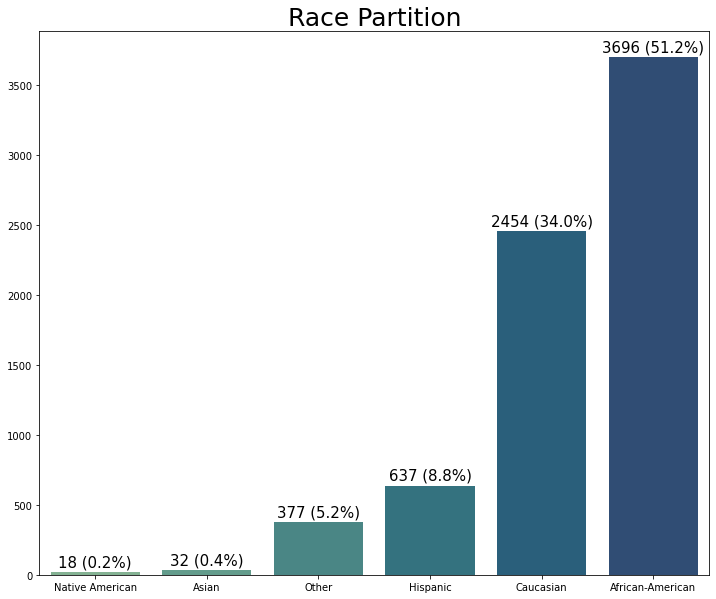

In [8]:
plot_protected_attribute(data_csv, protected_attribute)

## **Fairness Metrics on Original Dataset**

In [9]:
mean_diff, smoothed_empirical, disparate_impact = compute_metrics(dataset_orig_train,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff)
print("Equal Opportunity Difference = ", smoothed_empirical)
print("Disparate Impact = ", disparate_impact)

Statistical Parity Difference =  -0.13958879655278544
Equal Opportunity Difference =  0.30441358652016726
Disparate Impact =  0.7704257150088586


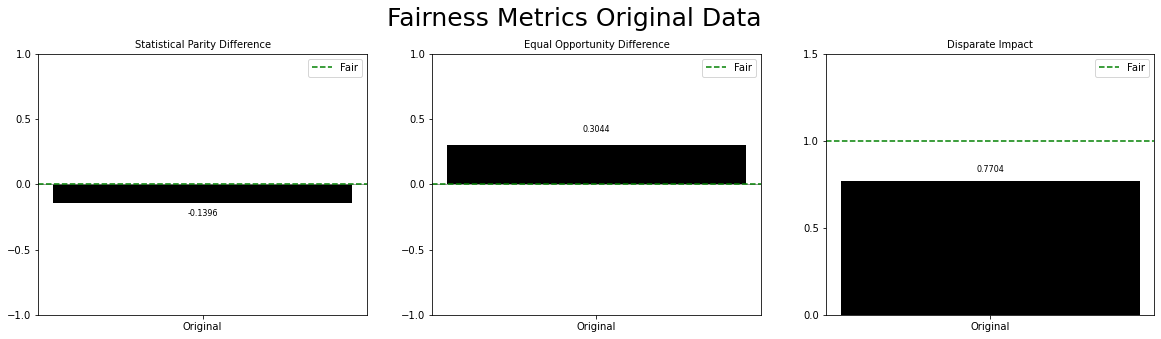

In [10]:
plot_fairness_metrics(np.array([mean_diff]), np.array([smoothed_empirical]), np.array([disparate_impact]), 
                      comp = False, processing_techinque = 'Original Data')

## **Processing Techniques**

## Reweighing Pre-Processing

In [11]:
processing = Processing(privileged_groups_race, unprivileged_groups_race)

In [12]:
transformed_train_data = processing.reweighing_processing(dataset_orig_train)
transformed_test_data = processing.reweighing_processing(dataset_orig_test)

In [13]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train_data,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  0.0
Equal Opportunity Difference =  1.1953437593970051e-05
Disparate Impact =  1.0


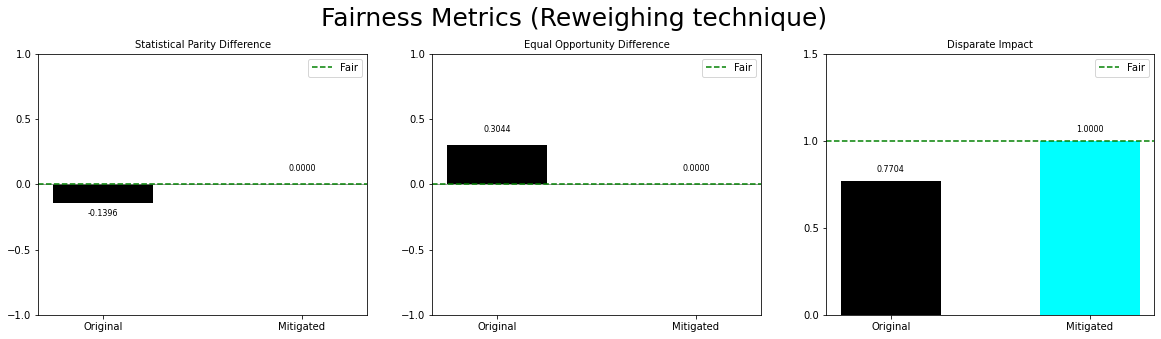

In [14]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Reweighing technique)')

## Training Models


### Logistic Regression

In [15]:
models_origin = Models(dataset_orig_train, dataset_orig_test)
models_transf = Models(transformed_train_data, transformed_test_data)

logistic_reg_orig, metrics_org_lg, confusion_matrix_org_lg = models_origin.logistic_regression()
logistic_reg_trans, metrics_trans_lg, confusion_matrix_trans_lg = models_transf.logistic_regression()

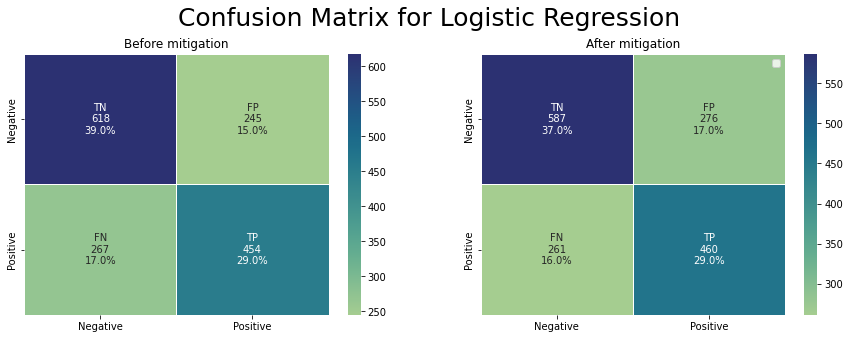

In [16]:
confusion_matrix(confusion_matrix_org_lg, confusion_matrix_trans_lg, 'Logistic Regression')

### Random Forest

In [17]:
models_origin = Models(dataset_orig_train, dataset_orig_test)
models_transf = Models(transformed_train_data, transformed_test_data)
rf_orig, metrics_org_rf, confusion_matrix_org_rf = models_origin.random_forest()
rf_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

In [18]:
metrics_org_rf

{'Accuracy': 0.6710858585858586,
 'Recall': 0.5852981969486823,
 'Precision': 0.65527950310559,
 'F1 Score': 0.6183150183150183}

In [19]:
metrics_transf

{'Accuracy': 0.6609848484848485,
 'Recall': 0.6380027739251041,
 'Precision': 0.625,
 'F1 Score': 0.6314344543582704}

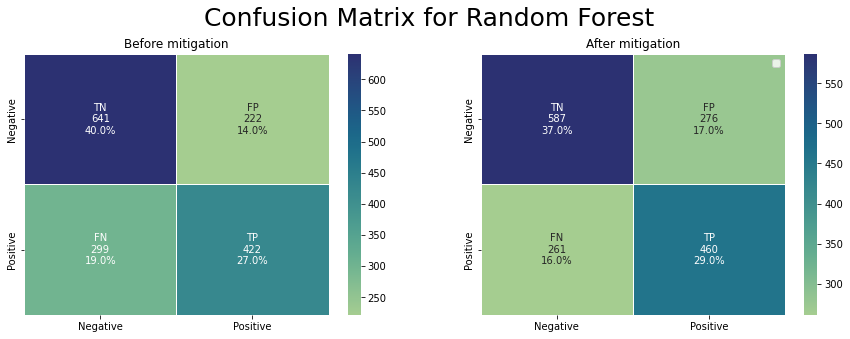

In [20]:
confusion_matrix(confusion_matrix_org_rf, confusion_matrix_transf, 'Random Forest')

### SVM

In [21]:
models_origin = Models(dataset_orig_train, dataset_orig_test)
models_transf = Models(transformed_train_data, transformed_test_data)
svm_orig, metrics_org_svm, confusion_matrix_org_svm = models_origin.svm()
svm_orig, metrics_transf, confusion_matrix_transf = models_transf.svm()

In [22]:
metrics_org_svm

{'Accuracy': 0.6584595959595959,
 'Recall': 0.6851595006934813,
 'Precision': 0.6113861386138614,
 'F1 Score': 0.6461739699149771}

In [23]:
metrics_transf

{'Accuracy': 0.6584595959595959,
 'Recall': 0.6851595006934813,
 'Precision': 0.6113861386138614,
 'F1 Score': 0.6461739699149771}

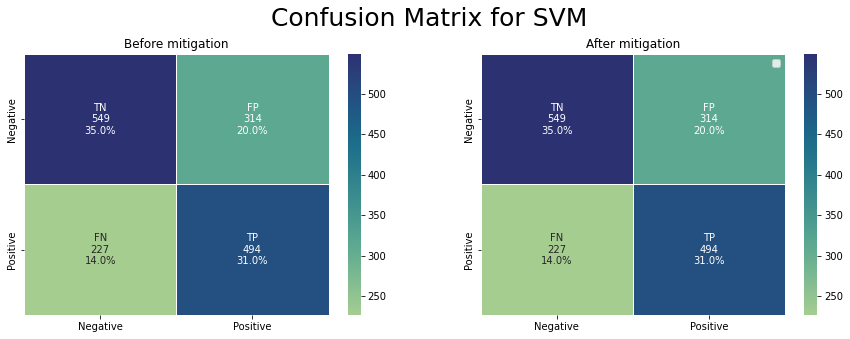

In [24]:
confusion_matrix(confusion_matrix_org_svm, confusion_matrix_transf, 'SVM')

## Opt Pre-Processing

In [25]:
optim_options = {
        "distortion_fun": get_distortion_compas,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]}
transformed_train_data = processing.optim_pre_processing(dataset_orig_train, optim_options)
transformed_test_data = processing.optim_pre_processing(dataset_orig_test, optim_options)

/usr/local/lib/python3.9/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/cvxpy/expressi

Optimized Preprocessing: Objective converged to 0.000736


/usr/local/lib/python3.9/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/cvxpy/expressi

Optimized Preprocessing: Objective converged to 0.000000


In [26]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train_data,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  -0.04882794706063409
Equal Opportunity Difference =  0.10335974699629191
Disparate Impact =  0.9115338073330544


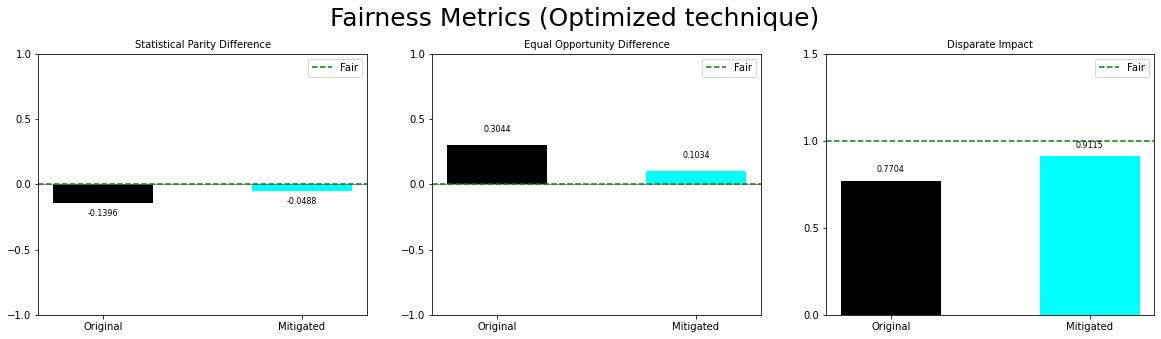

In [27]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Optimized technique)')

### Logistic Regression

In [28]:
models_transf = Models(transformed_train_data, transformed_test_data)
logistic_reg_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

In [29]:
metrics_transf

{'Accuracy': 0.6736111111111112,
 'Recall': 0.6072931276297335,
 'Precision': 0.6462686567164179,
 'F1 Score': 0.626174981923355}

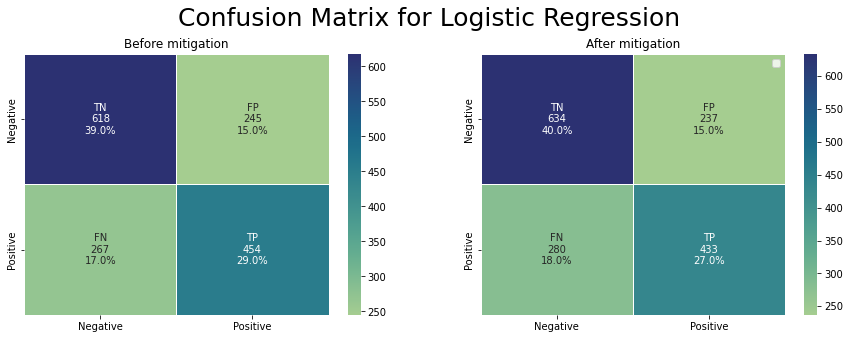

In [30]:
confusion_matrix(confusion_matrix_org_lg, confusion_matrix_transf, 'Logistic Regression')

### Random Forest

In [31]:
models_transf = Models(transformed_train_data, transformed_test_data)
rf_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

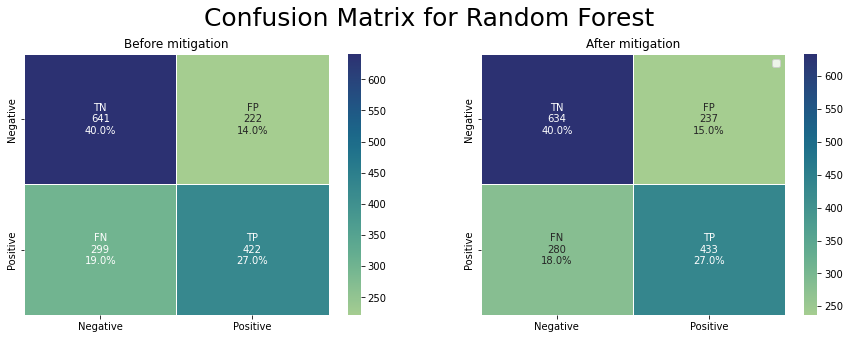

In [32]:
confusion_matrix(confusion_matrix_org_rf, confusion_matrix_transf, 'Random Forest')

### SVM

In [33]:
models_transf = Models(transformed_train_data, transformed_test_data)
svm_trans, metrics_transf, confusion_matrix_transf = models_transf.svm()

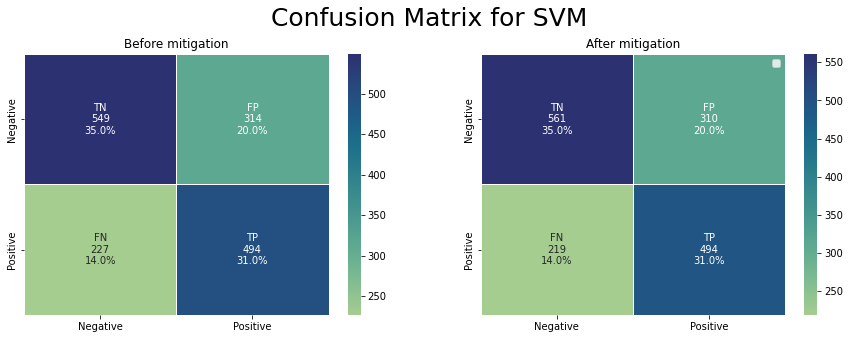

In [34]:
confusion_matrix(confusion_matrix_org_svm, confusion_matrix_transf, 'SVM')

## Adversarial In-Processing 

In [35]:
transformed_train, transformed_test = processing.adversarial_debiasing_processing(dataset_orig_train, dataset_orig_test, session, 'plain_classifier', True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.691907; batch adversarial loss: 0.701874
epoch 1; iter: 0; batch classifier loss: 0.639478; batch adversarial loss: 0.788991
epoch 2; iter: 0; batch classifier loss: 0.659206; batch adversarial loss: 0.738814
epoch 3; iter: 0; batch classifier loss: 0.574101; batch adversarial loss: 0.761819
epoch 4; iter: 0; batch classifier loss: 0.641774; batch adversarial loss: 0.781184
epoch 5; iter: 0; batch classifier loss: 0.670790; batch adversarial loss: 0.747028
epoch 6; iter: 0; batch classifier loss: 0.571299; batch adversarial loss: 0.780237
epoch 7; iter: 0; batch classifier loss: 0.661027; batch adversarial loss: 0.692104
epoch 8; iter: 0; batch classifier loss: 0.673051; batch adversarial loss: 0.762394
epoch 9; iter: 0; batch classifier loss: 0.624945; batch adversarial loss: 0.760739
epoch 10; iter: 0; batch classifier loss: 0.639126; batch adversarial loss: 0.715610
epoch 11; iter: 0; batch classifier loss: 0.557315; batch adversarial loss:

In [36]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  -0.119972299168975
Equal Opportunity Difference =  0.30191250088821786
Disparate Impact =  0.8182161594963274


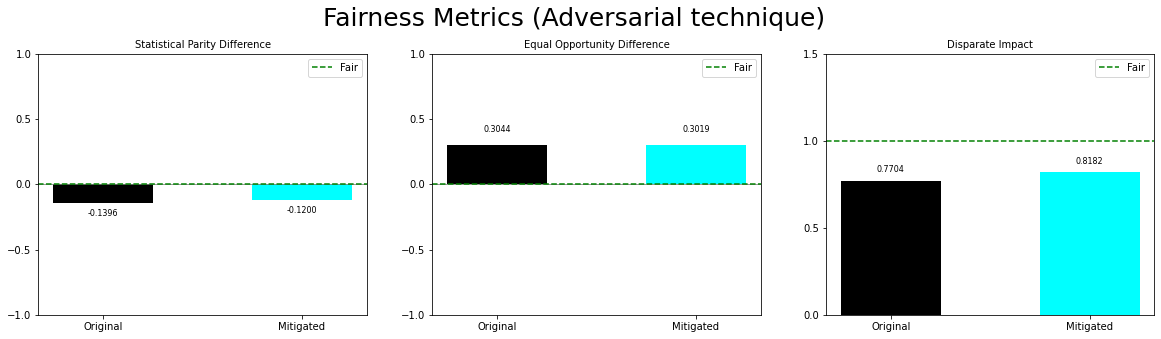

In [37]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Adversarial technique)')

In [38]:
models_transf = Models(transformed_train, transformed_test)
logistic_reg_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

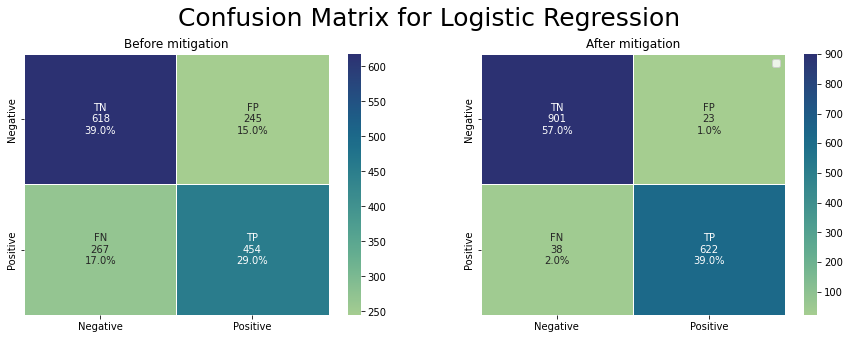

In [39]:
confusion_matrix(confusion_matrix_org_lg, confusion_matrix_transf, 'Logistic Regression')

In [40]:
models_transf = Models(transformed_train, transformed_test)
rf_trans, metrics_transf, confusion_matrix_transf = models_transf.random_forest()

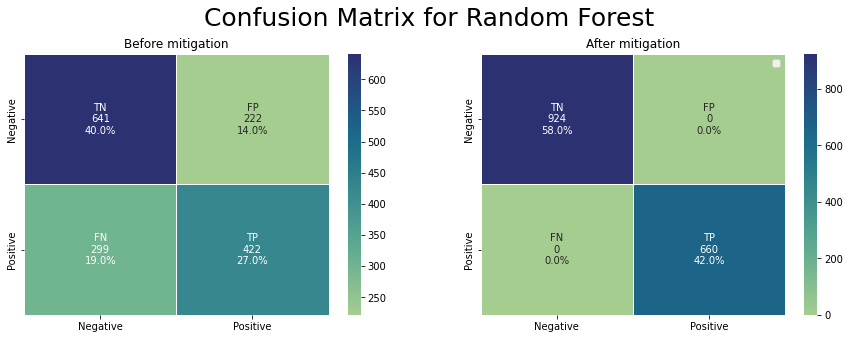

In [41]:
confusion_matrix(confusion_matrix_org_rf, confusion_matrix_transf, 'Random Forest')

In [42]:
models_transf = Models(transformed_train, transformed_test)
svm_trans, metrics_transf, confusion_matrix_transf = models_transf.svm()

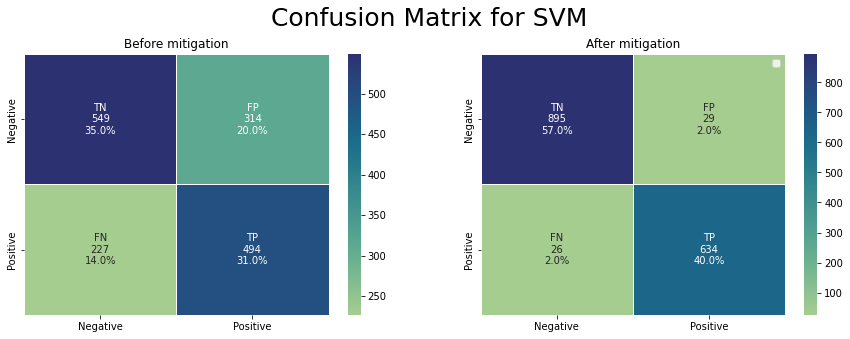

In [43]:
confusion_matrix(confusion_matrix_org_svm, confusion_matrix_transf, 'SVM')

# Equalized Calibrated Odds

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy = True)
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)
fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1, 1)

In [54]:
y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= 0.5] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= 0.5)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

In [55]:
transformed_train, transformed_test = processing.calibrated_eq_odds_processing(dataset_orig_train, 
                                                                               dataset_orig_train_pred, dataset_orig_test, cost_constraint = 'fnr', seed = 0)

In [56]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  -0.5315555555555556
Equal Opportunity Difference =  7.337037847548158
Disparate Impact =  0.46844444444444444


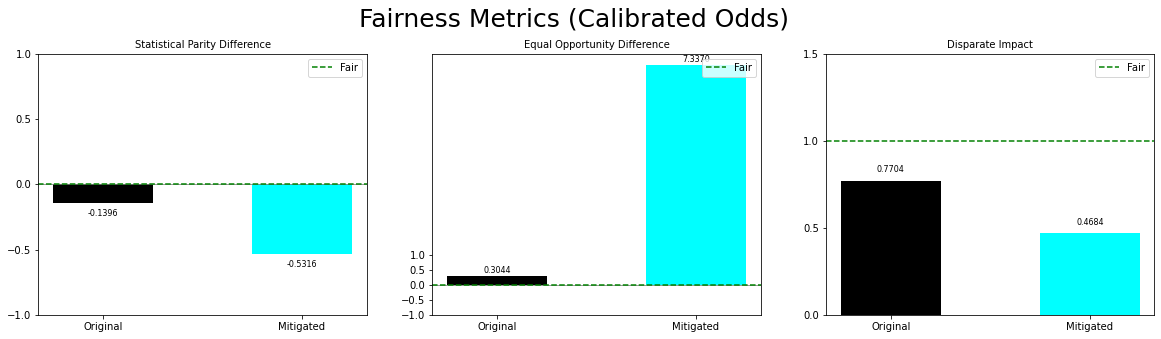

In [57]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Calibrated Odds)')

In [49]:
from aif360.metrics import ClassificationMetric
from IPython.display import Markdown, display

cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups = unprivileged_groups_race,
                             privileged_groups = privileged_groups_race)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
-0.12909866093707523
Difference in GFNR between unprivileged and privileged groups
0.11805685730234283


In [58]:
models_transf = Models(transformed_train, transformed_test)
logistic_reg_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

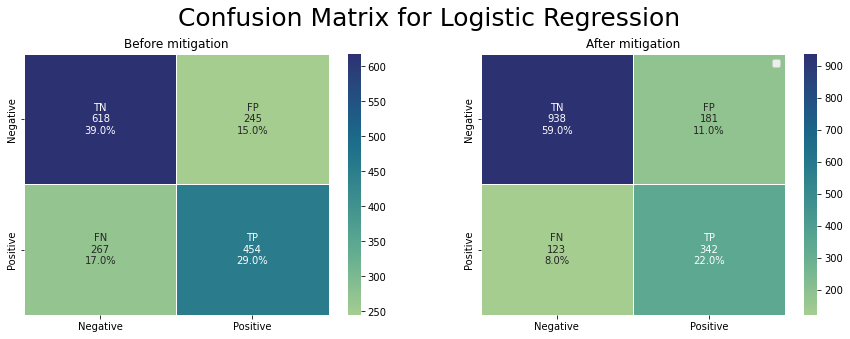

In [59]:
confusion_matrix(confusion_matrix_org_lg, confusion_matrix_transf, 'Logistic Regression')

In [60]:
models_transf = Models(transformed_train, transformed_test)
rf_trans, metrics_transf, confusion_matrix_transf = models_transf.random_forest()

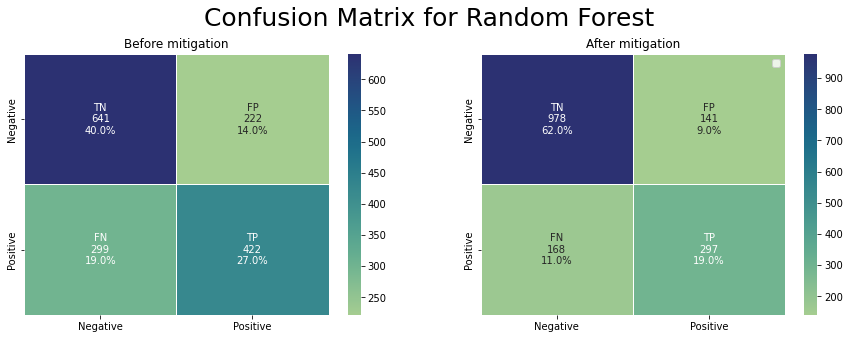

In [61]:
confusion_matrix(confusion_matrix_org_rf, confusion_matrix_transf, 'Random Forest')